# Model

## Oil producer's problem

$$
    \pi = \max \begin{cases}
        \overbrace{R_o + R_g}^{R_t}  - c_g & \text{ gather}\\
        R_o - (c_f + \tau) & \text{ flare + tax} \\
        V_a & \text{ alternative}
        \end{cases}
$$
We then have
$$
Flare \succsim Gather  \iff   (c_f+\tau) \geq c_g - R_g
$$

$$
Alt   \succsim Gather  \iff  V_a        \geq R_o + R_g - c_g
$$

$$
Alt    \succsim Flare  \iff  V_a        \geq R_o - (c_f + \tau)
$$

Define indifference thresholds
$$
c^*_f(c_g) = c_g - R_g - \tau \qquad \qquad V^*_a(c_g) = R_o + R_g - c_g
$$

Derivatives wrt $c_g,\tau$ are
$$
\frac{d c_f^*}{d c_g} = 1 \qquad
\frac{d c_f^*}{d \tau} = -1 \qquad
\frac{d V_a^*}{d c_g} = -1 \qquad
\frac{d V_a^*}{d \tau} = 0 
$$

Assume that flaring costs & outside options are uniformly distributed w/ mass equal to upper limit: $c_f \sim  \bar c_f \times U(0, \bar c_f)$ and $V_a \sim \times \bar V_a U(0,\bar V_a)$. Then quantities outcomes and derivatives wrt $c_g$ are the follwoing:

Gathering -
$$
G = V_a^*(\bar c_f - c_f^*) \qquad G' = -[V_a^* + (\bar c_f - c_f^*)]
$$

Flaring - 
$$
F = c_f^*[V_a^* + \frac 1 2 c_f^*] \qquad F' = V_a^*
$$

Alternative/Outside Option
$$
A = \bar c_f(\bar V_a - V_a^*) - \frac 1 2 (c_f^*)^2 \qquad A' = (\bar c_f - c_f^*)
$$

## Processor profits

$$
    W = c_g G - \kappa(G)
$$
In the competitive case we have
$$
    c_g = \kappa'(G)
$$
But in a monopolistic case, FOC imply a markup
$$
    c_g = \kappa'(G) - \underbrace{\frac{G}{G'}}_{<0} > \kappa'(G)
$$
Under a constant MC, $\kappa(G) = \kappa_0 G$, we end up with a quadratic function of $c_g^*$, and then we solve for the lower quadratic root. The algebra is awful to sign $\frac{d c_g}{d\tau}$ under monopolistic competition... so I do it numerically.

## Analysis

Monopolistic behavior results in a MUCH bigger markup on processing, and more flaring. When we impose a tax, the monopolist actually *increases* the price of its services.

The "outside option" $V^a$ will include other processors... so we can think about this model as a case of a Nash-Bertrand equilibrium a price-setting game with monopolistic competition (as one would do in BLP...). Practically speaking, we could think about a processor on a network who knows they face a downward-sloping demand curve because the wells close to them are unlikely to switch to an alternative, far-away processor if the processor raises the price a bit.

# Installaion of package

Install `ToyFlaringModel.jl` in Julia, and then "instantiate" it to install dependencies
Note that the `]` will put Julia into "package" mode, so you won't need the second `]`

```julia
]dev https://github.com/magerton/ToyFlaringModel.jl
]instantiate ToyFlaringModel
```

# Installing Jupyter notebooks

To run this notebook, you'll need to install IJulia (see https://github.com/JuliaLang/IJulia.jl). 

Once you install Julia, you'll need to install IJulia with `]add IJulia`. Then open up the Julia command line and ask for a Jupyter notebook

```julia
using IJulia
jupyterlab()
```

You can also create a shortcut on Windows. For example, my shortcut `Target` is `D:\libraries\julia\conda\3\Scripts\jupyter-lab.exe`, and the `Start in` location is `E:\projects\`

In [1]:
using ToyFlaringModel
using Plots
using ForwardDiff
gr(fmt=:png)

Plots.GRBackend()

In [2]:
mc = FlaringModel(;monop=false)
mm = FlaringModel(;monop=true)

FlaringModel(2.0, 1.0, 4.0, 4.0, 1.25, true)

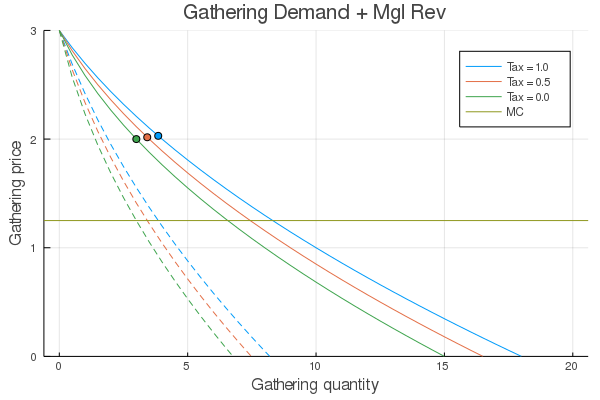

In [3]:
using ToyFlaringModel: Ro, Rt, Rg, cbar

# is negative root of quadratic
function inversedemand(m,g,t)
    B = -(Rt(m) + Rg(m) + t + cbar(m))
    C = Rt(m)*(Rg(m)+t+cbar(m)) - g
    x = (- B - sqrt(B^2 - 4*C))/2
    return x
end

inversedemandp(m,g,t) = ForwardDiff.derivative(x -> inversedemand(m,x,t), g)

mr(m,g,t) = inversedemandp(m,g,t)*g + inversedemand(m,g,t)

qs = 0:0.5:20
taxes = [1, 1/2, 0]

p = plot(;title="Gathering Demand + Mgl Rev", ylab="Gathering price", xlab = "Gathering quantity", ylim=(0,Inf))
for (i,t) in enumerate(taxes)
    plot!(p, qs, q -> inversedemand(mm,q,t), label="Tax = $t", linecolor=i)
    plot!(p, qs, q -> mr(mm,q,t),            label="",         linecolor=i, linestyle=:dash)
    scatter!(p,[Gather(mm,t)], [Cost(mm,t)], label="",         color=i )
end
hline!(p,[mm.k0], label="MC")
png(p,"gathering-demand.png")
plot(p)

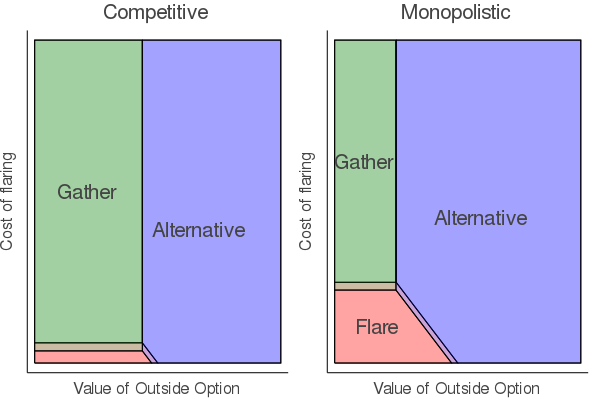

In [4]:
function PlotModel(m::FlaringModel, t0=0, t1=0.1)
    p = plot(; xticks=0, yticks=0, xlab="Value of Outside Option", ylab="Cost of flaring")
    plot!(p, GatherShape(m,t0); fillalpha=0.2, label="", fillcolor=:green)
    plot!(p, FlareShape( m,t0); fillalpha=0.2, label="", fillcolor=:red)
    plot!(p, AltOptShape(m,t0); fillalpha=0.2, label="", fillcolor=:blue)

    plot!(p, GatherShape(m,t1), fillalpha=0.2, label="", fillcolor=:green)
    plot!(p, FlareShape( m,t1), fillalpha=0.2, label="", fillcolor=:red)
    plot!(p, AltOptShape(m,t1), fillalpha=0.2, label="", fillcolor=:blue)

    annotate!([GatherLab(m,t0)])
    annotate!([AltOptLab(m,t0)])

    return p
end

p1 = PlotModel(mc, 0, 0.1)
title!(p1, "Competitive")
p2 = PlotModel(mm, 0, 0.1)
title!(p2, "Monopolistic")
annotate!(p2, [FlareLab(mm,0.1)])
p3 = plot(p1,p2)
png("competitive-vs-monopolistic.png")
plot(p3)

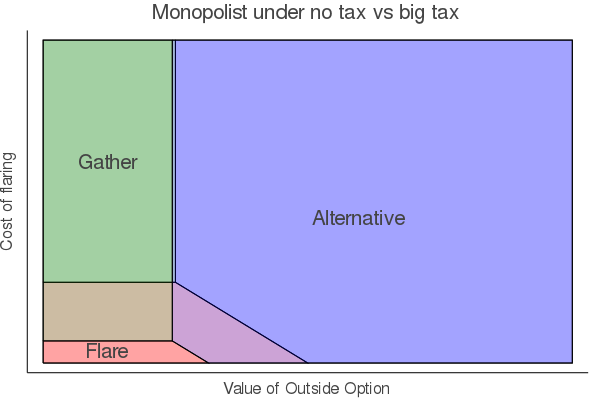

In [5]:
p = PlotModel(mm, 0, 0.75)
title!(p, "Monopolist under no tax vs big tax")
annotate!(p, [(0.5, 0.15, "Flare")])
png(p, "monopolist-with-tax.png")
plot!(p)

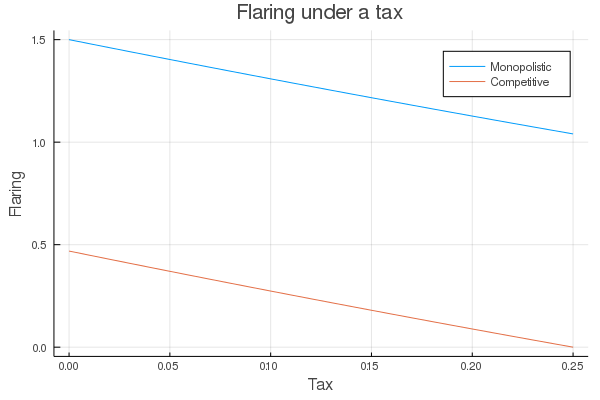

In [6]:
taxes = 0:0.01:0.25
p = plot(; title="Flaring under a tax", xlab="Tax", ylab="Flaring")
plot!(p, taxes, t -> Flare(mm, t), label="Monopolistic")
plot!(p, taxes, t -> Flare(mc, t), label="Competitive")
png(p, "flaring-under-tax.png")
plot!(p)

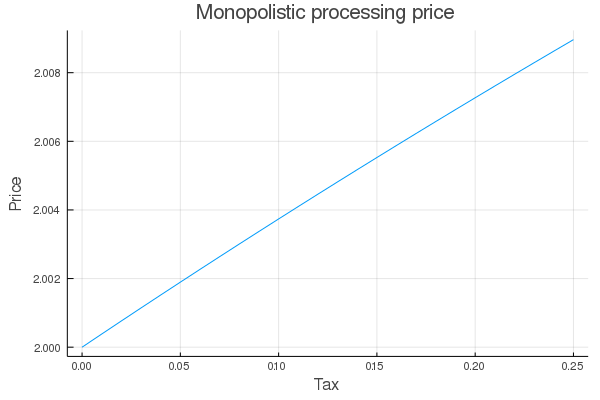

In [8]:
p = plot(; title="Monopolistic processing price", xlab="Tax", ylab="Price")
plot!(p, taxes, t -> Cost(mm, t), label="")
png(p, "monopolist-overshifts-tax.png")
plot(p)